# Gift shop customer segmentation(clustering tasks)

## 1. Statement of the problem


In this project we will solve a business problem in the field of marketing. It is necessary to segment customers based on their purchasing power, the frequency of orders and the period of limitation of the last order, as well as determine the optimal strategy for interacting with them.
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

**Business task:** segment existing customers, interpret these segments and determine a strategy for interacting with them.

**Technical task of Data Science:** build a customer clustering model based on their purchasing power, frequency of orders and the period of limitation of the last purchase, determine the profile of each of the clusters.

**Main goals of the project:**
1. Pre-process the data set.
2. Conduct exploratory data analysis and identify key patterns.
3. Create product and customer categories.
4. Build several machine learning models that solve the client clustering problem, determine the number of clusters and interpret them.
5. Design a process for predicting a client's interest category and test your model on new clients.



## 2. Getting to know your data.  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

The first step is to understand what data we have to work with and perform basic data preprocessing, converting the features into the formats necessary for further work.

First, let's take a look at our data:

In [3]:
data = pd.read_csv(
    "customer_segmentation_project.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


So we have data on over half a million transactions. Each of them is described by the following characteristics:

* InvoiceNo - invoice number (a unique nominal six-digit number assigned to each transaction; the letter "C" at the beginning of the code indicates the cancellation of the transaction);
* Stock Code - product code (a unique five-digit integer assigned to each individual product);
* Description — product name;
* Quantity - quantity of each product per transaction;
* InvoiceDate — date and time of invoice/transaction;
* UnitPrice — price per unit of goods in pounds sterling;
* CustomerID — client identifier (a unique five-digit number uniquely assigned to each client);
* Country - the name of the country in which the client lives.

Let's analyze the structure of the table.


### Let's see how many columns in the data are encoded with numeric types (int/float).

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


### Let's see what happens with the passes.

In [5]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Judging by the description of the task, we should have been provided with data for an annual period - let's check if this is true.

Let's convert the InvoiceDate column to datetime format.
Let us indicate for what period of time the data is presented:


In [6]:
data.InvoiceDate = pd.to_datetime(data.InvoiceDate)
print(data.InvoiceDate.min())
print(data.InvoiceDate.max())


2010-12-01 08:26:00
2011-12-09 12:50:00


### Let's see what's interesting.

1) What is the maximum quantity of goods in an order (Quantity)?

2) What is the minimum quantity of goods in an order (Quantity)?

3) How much does the data indicate that the cheapest item (excluding items with negative costs) costs?

In [7]:
data.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [8]:
data[data['UnitPrice']>=0]['UnitPrice'].min()


0.0

The cheapest product costs nothing :)

### We will answer the questions:
1) How many unique customers purchased goods during the period of uploading the dataset?

2) How many unique countries are there in the Country column (excluding the special 'Unspecified' code that denotes an unspecified country)?

3) Specify the identifier of the most popular product (StockCode).

In [9]:
print('Number of unique clients: ', data.CustomerID.nunique())
print('Number of unique countries: ', data.Country.nunique())
print('Product Popularity:\n', data.StockCode.value_counts())

Number of unique clients:  4372
Number of unique countries:  38
Product Popularity:
 85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
21431        1
22275        1
17001        1
90187A       1
72759        1
Name: StockCode, Length: 4070, dtype: int64


## 3. Preprocessing and data cleaning

At this stage, we have to prepare our dataset for further modeling by cleaning the data.

### Let's start with the passes.

1) How many missing values are there in the table?

2) Gaps in the column with the customer ID and product description indicate incorrect/incomplete transactions.

Remove rows that contain gaps in these columns. How many rows are left in the table?

In [10]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [11]:
data = data.dropna(subset=['Description', 'CustomerID'])
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB


### Following the gaps, we will check for duplicates.

1) How many completely duplicate records are there in the table?

2) Remove duplicates from the table. How many lines are left?


In [13]:
data.duplicated().sum() #duplicate

5225

In [14]:
data.drop_duplicates(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  object        
 7   Country      401604 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.6+ MB


Earlier we noticed that there are negative values in the product quantity column. Let's figure out where they came from. Let's display the first 5 rows of the table in which the Quantity column is less than 0.

In [15]:
negative_quantity = data[(data['Quantity']<0)]
print('Count of entries with a negative number: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


### Let's check that all records from the table with a negative quantity of goods are indeed return transactions. If a transaction is not a return, but contains a negative quantity of goods, this will be a reason to consider it an outlier.

How many transactions from the negative_quantity table do not contain a return flag in the order number?

In [16]:
print('Number of orders with signs of return: ', negative_quantity['InvoiceNo'].str.contains('C').count())

Number of orders with signs of return:  8872


In [17]:
print(f"All order numbers in the negative_quantity table are returnable: {negative_quantity.shape[0] == negative_quantity['InvoiceNo'].str.contains('C').count()}")

temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

All order numbers in the negative_quantity table are returnable: True


,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


Let's take a closer look at returns. Currently, each unique product has a separate row in the table - this makes it difficult to determine the total number of returns.

To count the number of returns, you first need to determine how many unique items are in the transaction (basket) for each unique customer-order pair:


In [18]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


### Let's add an order cancellation attribute (order_canceled) to the auxiliary table nb_products_per_basket: it is equal to 1 if the transaction is a return, and 0 otherwise.

What percentage of orders in the table are returns?


In [19]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if x[0] == 'C' else 0)
round(nb_products_per_basket['order_canceled'].value_counts()[1] / nb_products_per_basket.shape[0] *100)

16

Let's take a closer look at the canceled orders:

In [20]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Let's find in the table with all transactions records belonging to the client with ID 12346:

In [21]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


So here is an example of an order-cancel pair. Note the StockCode, UnitPrice, CustomerID and Quantity columns and compare them for the two transactions.

### We put forward a hypothesis:
for each canceled transaction in the database (data table), there is its analogue with the same product code, customer ID and the opposite value of the product quantity.

In [22]:
returns = negative_quantity.copy()
returns.reset_index(inplace=True)
returns['Quantity'] = -returns['Quantity']
matched = pd.merge(returns, data,
                   on=['StockCode', 'CustomerID', 'Quantity'], how='inner')
matched.drop_duplicates(subset='index', inplace=True)
print(f'Number of mismatches: {negative_quantity.shape[0] - matched.shape[0]}')

Number of mismatches: 5626


Let's give a counter-example where our previous hypothesis stumbled. Let's look at the client with ID 14527:

In [23]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Let's pay attention to the first line, which contains order C536379 with a cancellation sign - we will not find any analogues opposite to it in terms of the number of goods. The reason lies in the type of product: this product is designated as a discounted product (StockCode), and, apparently, for such transactions there are no analogues with a positive number of items in the order. Let's take this observation into account for the future.

### We put forward a new hypothesis:
for each canceled transaction in the database (data table), there is its analogue with the same product code, customer ID and the opposite value of the quantity of the product, if the product is not subject to discounts.

In [24]:
returns = negative_quantity.copy()
returns.reset_index(inplace=True)
returns['Quantity'] = -returns['Quantity']
returns = returns[~returns['StockCode'].str.contains('D')]
matched = pd.merge(returns, data,
                   on=['StockCode', 'CustomerID', 'Quantity'], how='inner')
matched.drop_duplicates(subset='index', inplace=True)
print(f'Number of mismatches: {negative_quantity.shape[0] - matched.shape[0]}')

Number of mismatches: 5634


Let's see where our problem lies. As a counter-example, here are transactions related to a client with ID 15311 and product code 35004C:

In [25]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* On the first line we see an order with cancellation (the order number begins with the symbol C). However, the question arises: what order did this cancellation come from, since there are no earlier records of transactions associated with this customer.
The answer is that the order for the purchase of this product from the client was received before December 2010, and this data is not in our table. This is a very popular problem that arises in almost any transaction work: there is only a fragment of the general data, but it is not known what preceded this fragment.

* The next two lines show that the client can cancel not the entire order, but only part of it (on December 5, the client buys 12 units of goods, and on December 8 issues a return for only one unit of goods). We need to take this into account for the future

So, now we know all the features of canceling orders. When segmenting customers, we will determine their purchasing power, and for this it is very important to take into account product returns. Therefore, let's create a QuantityCanceled attribute in the transaction data, which will indicate the quantity of goods subsequently returned for each transaction.

Let's immediately say that we will not take into account complex edge cases:
1. The canceled transaction does not have an opposite one (there were no purchase transactions for the return transaction).
2. The quantity of returned goods in a return transaction is greater than the quantity of goods indicated in any of the individual purchase transactions (this is the case when the client made several orders of the same product, and then issued a return for all goods at once).


The get_quantity_canceled() function takes as input a table with transactions and returns a Series object - a column that indicates the quantity of goods subsequently returned for each transaction. Based on the result of this function, we create a new column QuantityCanceled in the table with transactions.

In [26]:
def get_quantity_canceled(data):
    # Initialize with zeros Series of the same length as the table columns
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Create a DataFrame from all transactions opposite returns
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # A return transaction has no opposite - we do nothing
        if (df_test.shape[0] == 0): 
            continue
        # A return transaction has only one opposite transaction
        # Add the quantity of returned goods to the QuantityCanceled column
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # A return transaction has multiple opposite transactions
        # We enter the quantity of the returned product in the QuantityCanceled column for the purchase transaction
        # in which the quantity of goods > (-1) * (number of goods in the return transaction)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

data['QuantityCanceled'] = get_quantity_canceled(data)

### Let's calculate the total number of canceled products in the QuantityCanceled column.

In [27]:
data['QuantityCanceled'].sum()

245266.0

##### Now that we have dealt with return transactions, we will no longer need them. Let's remove from the table transactions whose field indicates a negative quantity of goods.
How many entries are left?

In [28]:
data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0


In [29]:
data = data.drop(data[data['Quantity'] < 0].index)

The next problem is special types of transactions. For example, we have already seen that for discounted products the StockCode is designated as 'D'. Let's check if there are other special codes.

In [30]:
data.shape

(392732, 9)


Using regular expressions, we will find product codes (StockCode) that begin with Latin letters (the codes may contain numbers).

Searching for substrings in a column can be done using str.contains(). We use the string '^[a-zA-Z]+' as a search pattern. Set the regex parameter to True.

1) How many unique special transaction types did you find?

Special transactions do not characterize our clients, so we do not need such records. Let's remove all special transactions from the table.

2) How many entries are left?


In [31]:
data['Special_Code'] = data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)
unic_no = []
for index, row in data.iterrows():
    if (row['Special_Code'] is True) & (row['StockCode'] not in unic_no):
        unic_no.append(row['StockCode'])
unic_no
    


['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT']

In [32]:
data = data[~data['StockCode'].str.contains(pat='^[a-zA-Z]+', regex=True)]
data.shape

(391183, 10)


Previously, when looking at the descriptive statistics, we saw that some items were priced at £0.

1) In how many transactions is the unit price equal to 0?

2) There were less than 1% of such transactions, so you can simply get rid of them. Let's remove such transactions from the table. How many entries are left?



In [33]:
data[data['UnitPrice']==0].count()

InvoiceNo           33
StockCode           33
Description         33
Quantity            33
InvoiceDate         33
UnitPrice           33
CustomerID          33
Country             33
QuantityCanceled    33
Special_Code        33
dtype: int64

The data cleaning stage is completed. We recommend saving the result in a separate file so that you do not have to repeat these steps later.

In [34]:
data = data.drop(data[data['UnitPrice']==0].index)
data.shape

(391150, 10)

## 4. Intelligence data analysis

Now let's do some intelligence analysis and examine the transactions.

We face the following tasks:
* understand which countries customers buy more and more often;
* find out whether there is seasonality in sales (when people buy more often);
* create new features that will be needed in the future when creating a dataset about clients.



First, let's find out in which countries the clients live.

Let's build a graph showing the number of clients in each country. We need unique clients.

In [35]:
data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,Special_Code
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,False


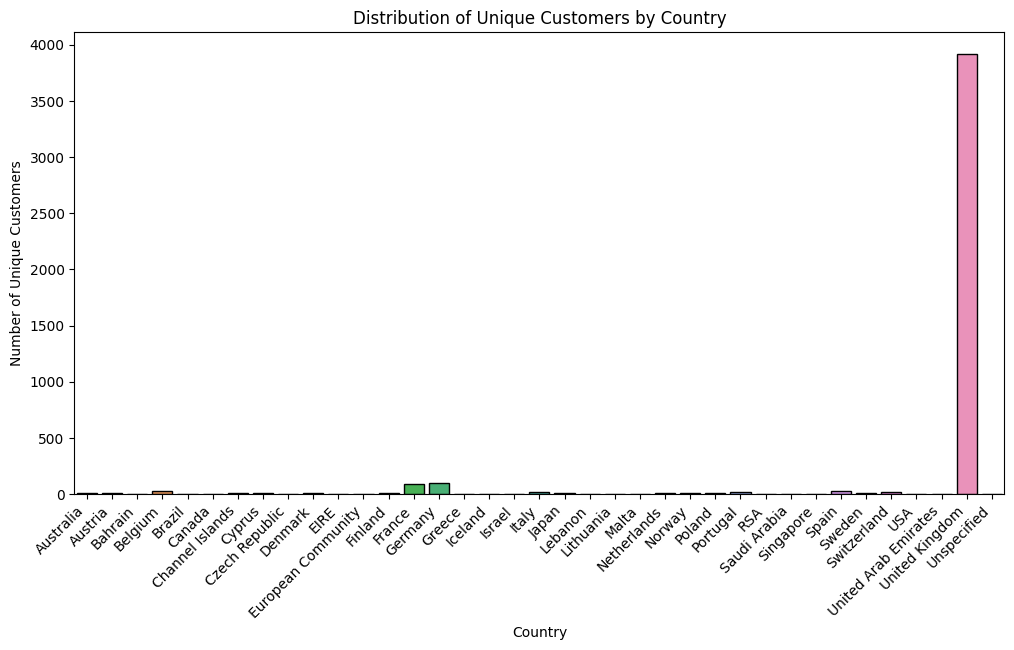

In [36]:
# Group the data by country and count the number of unique clients
customer_counts = data.groupby('Country')['CustomerID'].nunique().reset_index()

# Set the chart size
plt.figure(figsize=(12, 6))

# Create a bar chart
sns.barplot(x='Country', y='CustomerID', data=customer_counts)

# Setting up a schedule
plt.xlabel('Country')
plt.ylabel('Number of Unique Customers')
plt.title('Distribution of Unique Customers by Country')

# Rotate country names for better readability
plt.xticks(rotation=45, ha='right')

# Show the graph
plt.show()

Мы посмотрели на распределение клиентов в разрезе стран. А что насчёт заказов?

Построем визуализацию и выделим топ-3 стран по количеству поступающих заказов.

We looked at the distribution of clients by country. What about orders?

Let's build a visualization and highlight the top 3 countries by the number of incoming orders.


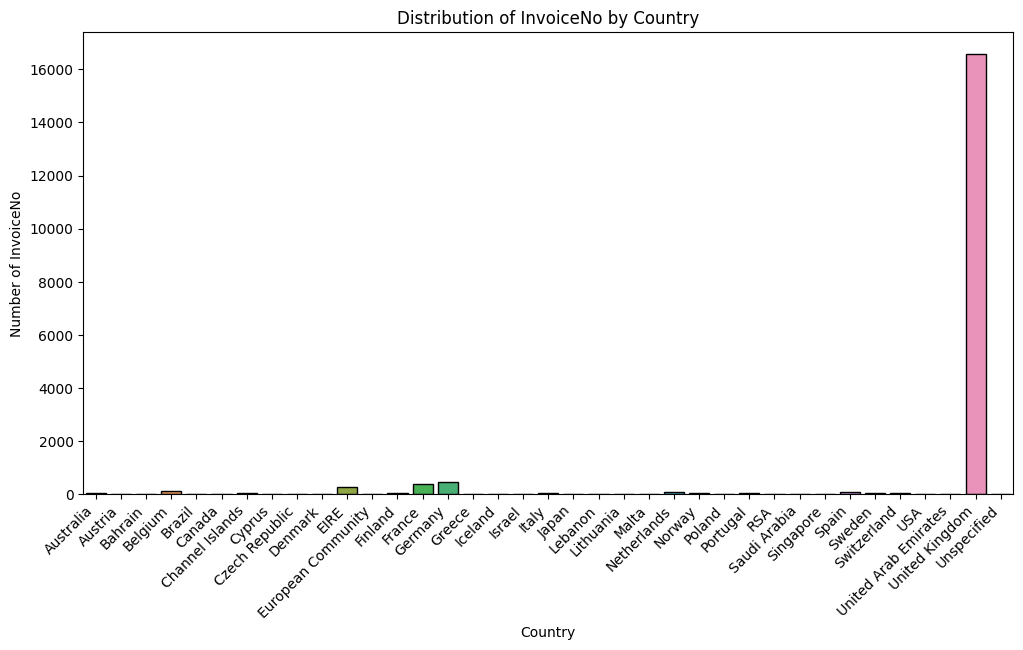

In [37]:
customer_counts = data.groupby('Country')['InvoiceNo'].nunique().reset_index()

# Set the chart size
plt.figure(figsize=(12, 6))

# Create a bar chart
sns.barplot(x='Country', y='InvoiceNo', data=customer_counts)

# Setting up a schedule
plt.xlabel('Country')
plt.ylabel('Number of InvoiceNo')
plt.title('Distribution of InvoiceNo by Country')

# Rotate country names for better readability
plt.xticks(rotation=45, ha='right')

# Show the graph
plt.show()

Let's add the total order price to the dataset, let's call it TotalPrice.
The total order price is calculated as:
 
  **total price = unit price * (number of goods in order - number of returned goods).**

What is the average total order value?

In [38]:
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])
round(data['TotalPrice'].mean())

21

Let’s build a visualization and highlight the top 3 countries whose clients bring the most revenue to the company:

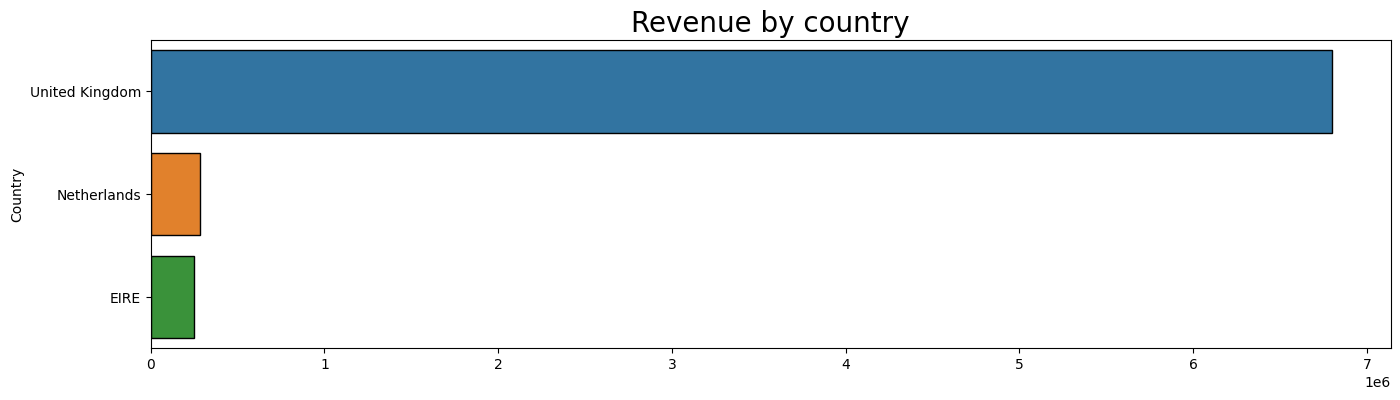

In [39]:
total_value = data.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)[:3]
fig, axes = plt.subplots(figsize=(16, 4))
sns.barplot(x=total_value.values, y=total_value.index)
axes.set_title('Revenue by country', fontsize=20);

__Interestingly, the Netherlands is in sixth place in terms of the number of orders, but due to the fact that these orders are wholesale, the Netherlands is in second place in terms of revenue.__

Now we are engaged in temporary well-being.

Let's add to the table with transactions the characteristics of the month, day of the week and hour of the purchase.

Let's build a visualization showing the distribution of total revenue from orders by month. We will indicate the number of the most profitable month for the company. Let's assume why this happens.

In [40]:
data['Month'] = data['InvoiceDate'].dt.month
data['day_of_week'] = data['InvoiceDate'].dt.day_of_week
data['Hour'] = data['InvoiceDate'].dt.hour


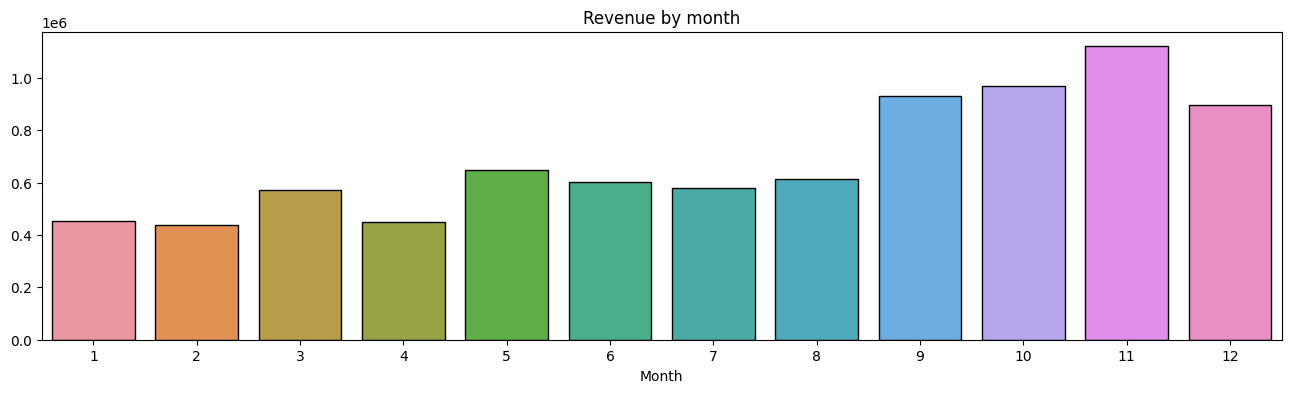

In [41]:
month_revenue = data.groupby('Month')['TotalPrice'].sum()
fig, axes = plt.subplots(figsize=(16, 4))
sns.barplot(x=month_revenue.index, y=month_revenue.values)
axes.set_title('Revenue by month');

__This result is explained quite simply: November precedes December, and in December Catholic Christmas and New Year are celebrated. Since we analyze gift store data, it is not at all surprising that we see the greatest increase in sales around these holidays.__

Let's build a visualization of the number of orders for each day of the week. Let's indicate the day of the week on which, according to the data, not a single order was made:

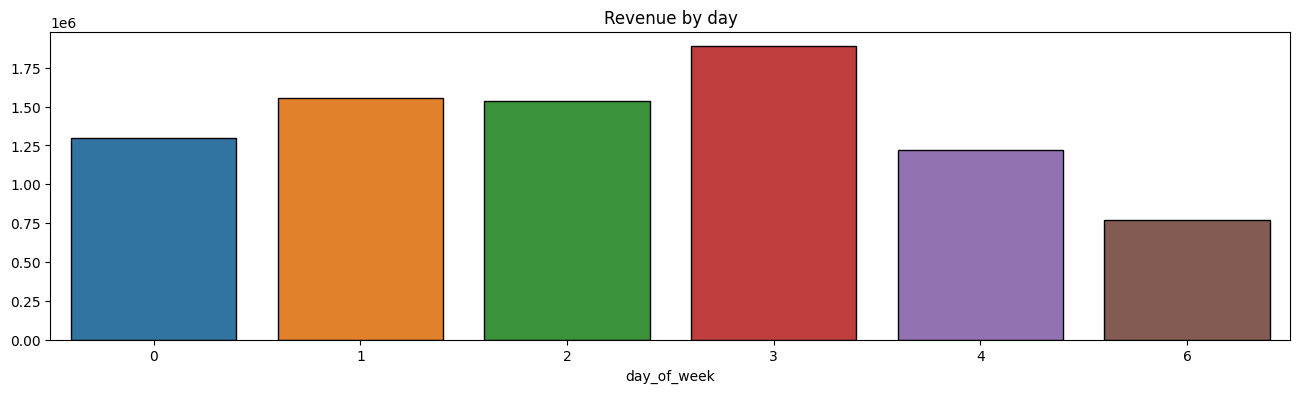

In [42]:
day_revenue = data.groupby('day_of_week')['TotalPrice'].sum()
fig, axes = plt.subplots(figsize=(16, 4))
sns.barplot(x=day_revenue.index, y=day_revenue.values)
axes.set_title('Revenue by day');

According to the data, there is not a single transaction made on Saturday, which is quite strange. Perhaps Saturday is a day off and transactions are not made on this day, or perhaps there is an error in the data.

Let's select the date from the time attribute of the transaction.
Let's group the data by dates and hours of the transaction and find the number of orders for each day and hour. Then we find the average number of daily incoming orders at each hour.

Let's build a visualization that reflects the distribution of the average number of daily incoming orders by time of day (hour of transaction).

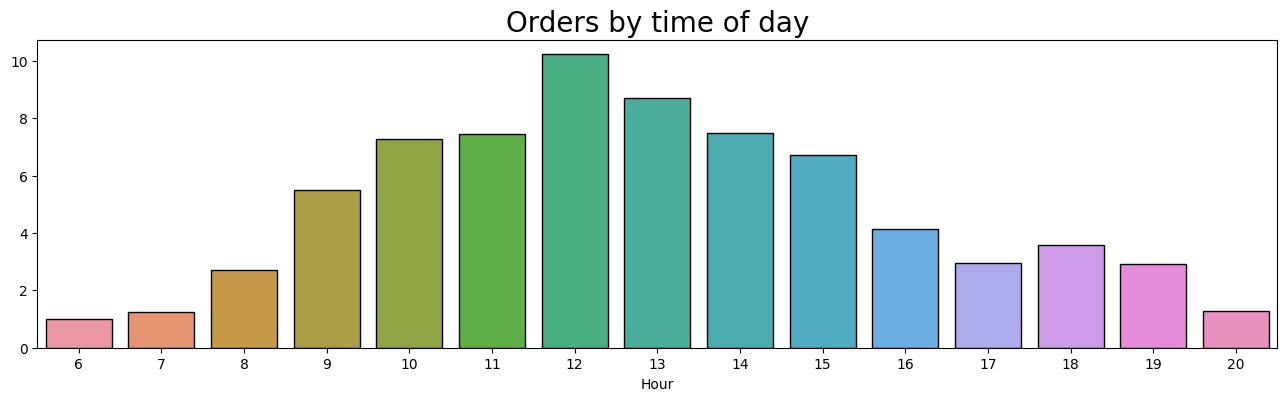

In [43]:
data['Date'] = data['InvoiceDate'].dt.date

date_hour = data.drop_duplicates(subset='InvoiceNo').groupby(
    ['Date', 'Hour'])['InvoiceNo'].count()
hourly = date_hour.groupby('Hour').mean()

fig, axes = plt.subplots(figsize=(16, 4))
sns.barplot(x=hourly.index, y=hourly.values)
axes.set_title('Orders by time of day', fontsize=20);

## 5. RFM customer segmentation: part 1

We have reached the most interesting part of our task. We have to formulate the characteristics on the basis of which we will segment customers.

RFM - method for analyzing customer value

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

The method consists of grouping clients based on the following parameters:
* Recency—recency of the client’s last purchase;
* Frequency - the total number of customer purchases;
* Monetary Value - how much money the client spent.

The essence of RFM analysis is that we divide all customers into groups depending on how long ago they made their last purchase, how often they bought and how large the amount of their orders was.

For example, this is what the interpretation of clusters might look like for the case of RF segmentation (analysis based on the recency and frequency of customer orders):


<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

The task of marketers is to lead the client to the loyal zone.

We can calculate RFM characteristics for each of the clients in our dataset and, based on them, using clustering methods, build similar client segments linked to our data.

### Let's start creating our RFM table.

To get the RFM table, we need to group the data by client IDs and calculate the following aggregate characteristics:

* Recency for the i-th client is calculated as the difference between the date and time of the last order and the reference point, converted into days:
     $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

     where $t_{ij}$ is the date and time the i-th client made his j-th purchase.

     As a starting point $t_0$ we take a date one day “older” than all our data. This will be December 10, 2011 (in datetime format - '2011-12-10 00:00:00').

* Frequency is calculated as the total number of unique orders made by the i-th client.
* Monetary Value is calculated as the total amount of money that the i-th customer spent on our products (including returns).

When we calculate all the characteristics, we will give the columns of the resulting table appropriate names.

1) Сколько клиентов совершили покупку более 200 дней назад?

2) Сколько заказов в среднем делает клиент (за представленный годовой период)? Ответ округлите до целого числа.

3) Чему равна общая сумма денег, которую потратил клиент с идентификатором 12360? Ответ приведите в фунтах стерлингов и округлите до целого числа.


In [44]:
import datetime
now_date = datetime.datetime(2011,12,10)
df_help = pd.DataFrame(columns=['Recency', 'Frequency', 'Monetary'], index=sorted(data['CustomerID'].unique()))
for i in df_help.index:
    df_help.loc[i, 'Recency'] = (now_date - data[data.CustomerID == i].InvoiceDate.max()).days
    df_help.loc[i, 'Frequency'] = len(data[data.CustomerID == i].InvoiceNo.unique())
    df_help.loc[i, 'Monetary'] = data[data.CustomerID == i].TotalPrice.sum()
    
print('Number of customers who made a purchase more than 200 days ago {}'.format(df_help[df_help.Recency>200].shape[0]))

Number of customers who made a purchase more than 200 days ago 743


In [45]:
df_help = df_help.rename_axis('CustomerID')
df_help


,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.0
12347,2,7,4310.0
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.4
...,...,...,...
18280,277,1,180.6
18281,180,1,80.82
18282,7,2,176.6


In [46]:
print('Average number of orders placed by a customer (for the annual period presented) - {}'.format(df_help.Frequency.mean()))
client_id = '12360'
print('Total amount of money spent by client ID {} (for example) - {:.0f}'.format(client_id, df_help.loc[client_id, 'Monetary']))

Average number of orders placed by a customer (for the annual period presented) - 4.2459621596677435
Total amount of money spent by client ID 12360 (for example) - 2302


Now let's take a look at the boxplots for each of the attributes:

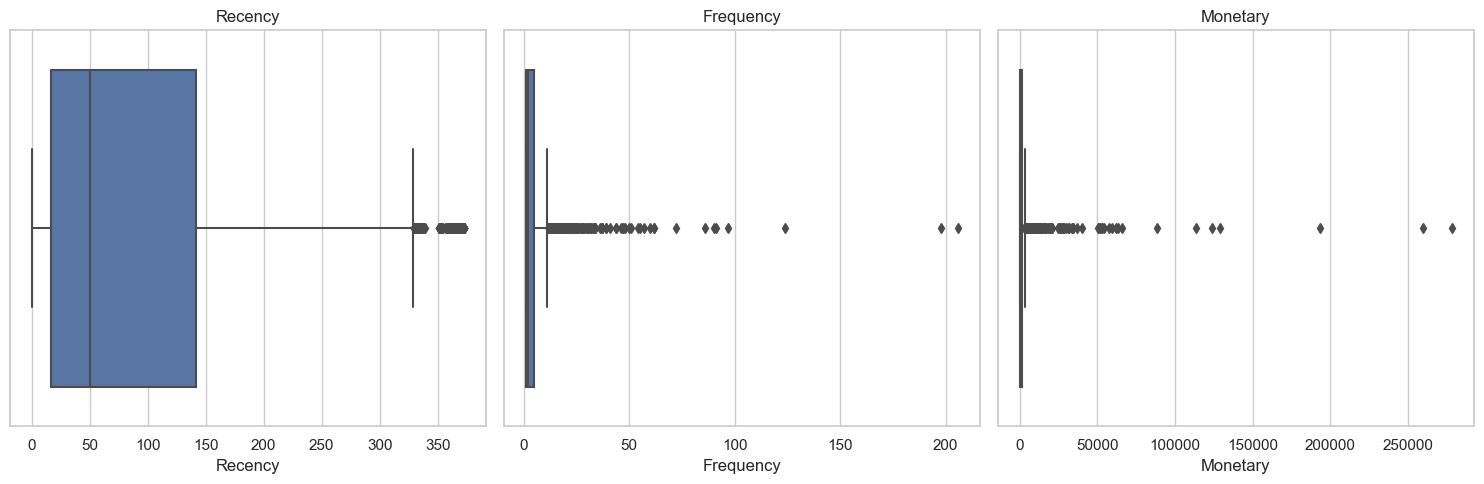

In [76]:
# Set the seaborn style for a more beautiful appearance of graphs
sns.set(style="whitegrid")

# Create a graph with multiple axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Subgraph names
titles = ["Recency", "Frequency", "Monetary"]

# Draw a boxplot for each column
for i, column in enumerate(df_help.columns):
    sns.boxplot(x=df_help[column], ax=axes[i])
    axes[i].set_title(titles[i])

# Adjust the distance between subgraphs
plt.tight_layout()

# Show the graph
plt.show()

What interesting things can you see here? There are customers with an abnormally large number of orders (more than 100 pieces), as well as customers whose total order value exceeds £190,000.

Why is this bad? Outliers can negatively affect the results of clustering methods that are not robust to them, such as the KMeans algorithm, so I would like to get rid of them. However, we also don’t want to lose a lot of valuable data about clients, so we will limit ourselves to the upper limit of the corresponding quantile at the level of 0.95. Therefore, we will delete the data of those clients whose Frequency parameter or Monetary parameter value is higher than 95% of clients.


Let’s remove from the RFM table records about clients for which at least one of the conditions is met:

$$frequency >frequency_{0.95}$$
$$monetary >monetary_{0.95}$$

where $frequency_{0.95}$ and $monetary_{0.95}$ are quantiles of the 0.95 level for the corresponding characteristics.

In [48]:
mask1 = df_help['Frequency'] <= df_help['Frequency'].quantile(0.95)
mask2 = df_help['Monetary'] <= df_help['Monetary'].quantile(0.95)
rfm_table_cleaned = df_help[mask1 & mask2]
print('There are data about {} clients left'.format(len(rfm_table_cleaned)))

There are data about 4044 clients left


After removing the outliers, you should end up with the following boxplots:

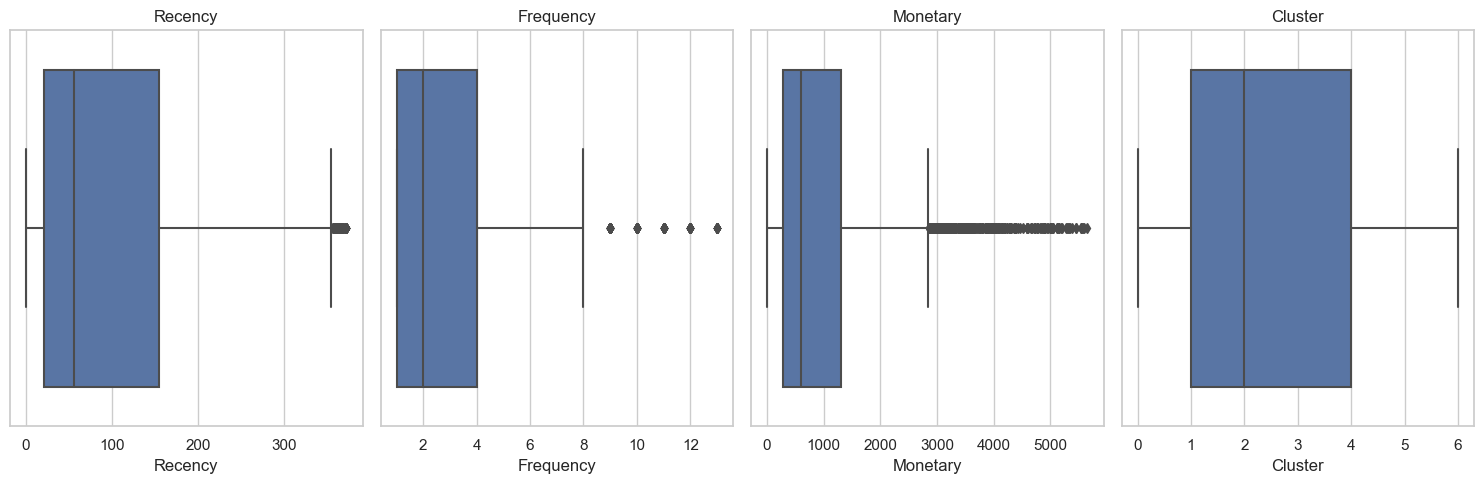

In [78]:
# Set the seaborn style for a more beautiful appearance of graphs
sns.set(style="whitegrid")

# Create a graph with multiple axes
fig, axes = plt.subplots(1, len(rfm_table_cleaned.columns), figsize=(15, 5))

# Subgraph names
titles = list(rfm_table_cleaned.columns)

# Draw a boxplot for each column
for i, column in enumerate(rfm_table_cleaned.columns):
    sns.boxplot(x=rfm_table_cleaned[column], ax=axes[i])
    axes[i].set_title(titles[i])

# Adjust the distance between subgraphs
plt.tight_layout()

# Show the graph
plt.show()

We have finally reached the clustering stage. First, we need to estimate how observations are distributed in feature space. Fortunately, we only have three parameters by which we want to cluster clients, so the data can be visualized in the form of a three-dimensional scatterplot.

Let's build a visualization of our three-dimensional feature space:


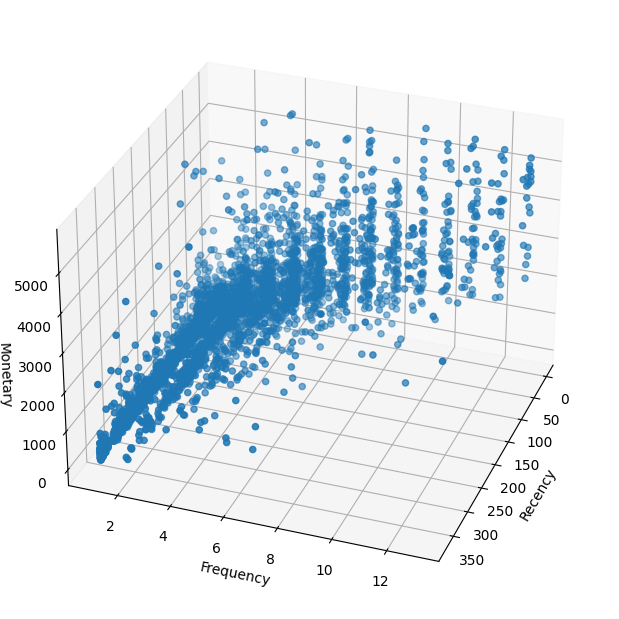

In [50]:
# create a three-dimensional object
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# add an additional axis to the image object
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# visualize the data by passing the x, y, z values, as well as information about grouping the data by color
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(), 
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary'].to_list()
)
# add axes
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


What can you see here? Actually, nothing specific. Yes, it is clear that there are clients with large values of the Monetary and Frequency parameters - these are probably the best clients who buy most often and bring in the most money. However, based on the total mass of points, it is difficult to say how many clusters we have - rather, it even seems that the space cannot be clustered.

Let's call on dimensionality reduction techniques to help.


### PCA
Let's start with principal component analysis (PCA). We know that for its stable operation the data needs to be standardized/normalized.

For convenience, let's wrap these data preprocessing steps in a pipeline.

Let's create a pipeline that will contain the following steps:
* standardization using StandardScaler with default parameters;
* principal component method with two components.

Let's train our pipeline on an RFM table cleared of outliers and apply a transformation to it.

What proportion of the variance in the original data is explained by the first principal component?

In [51]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('scaler', preprocessing.StandardScaler()), 
    ('pca', decomposition.PCA(n_components=2))
])
pca = pipeline.fit_transform(rfm_table_cleaned)
print('{:.2f}'.format(pipeline['pca'].explained_variance_ratio_[0]))

0.68


Having visualized the space of principal components after decomposition, we get the following picture:

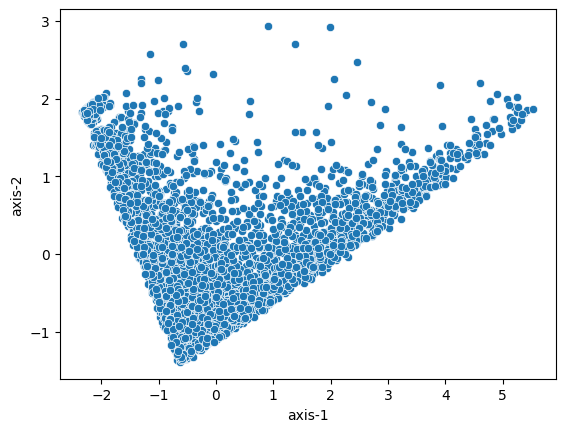

In [52]:
rfm_table_processed = pd.DataFrame(pca, columns=['axis-1', 'axis-2'])
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

Let's try to divide this space of principal components into segments.

### Let's try to use the k-means method.

Let's select the optimal number of clusters for the k-means method using the silhouette coefficient, sorting through possible values from 2 to 10 inclusive.

Let's take the number 42 as the value of the random_state parameter. Leave the remaining parameters as default.
Let's answer the questions:
1) Judging by the results obtained, what is the best number of clusters to take?

2) What is the maximum value of the silhouette coefficient?

Optimal number of clusters: 3
Maximum silhouette coefficient value: 0.52


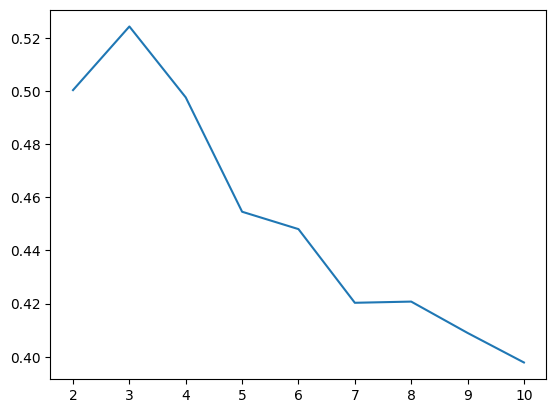

In [53]:
# import the silhouette metric
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

silhouette = []
for n_cl in range(2,11):
    kmeans = cluster.KMeans(n_cl, random_state=42)
    kmeans.fit(pca)
    silhouette.append(metrics.silhouette_score(pca, kmeans.labels_))
plt.plot(range(2,11), silhouette);
print(f'Optimal number of clusters: {np.argmax(silhouette) + 2}')
print(f'Maximum silhouette coefficient value: {max(silhouette):.2f}')

### Now let's take the EM algorithm.

Let's select the optimal number of clusters for the EM algorithm (Gaussian Mixture) using the silhouette coefficient, sorting through possible values from 2 to 10 inclusive.
Let's take the number 42 as the value of the random_state parameter. Leave the remaining parameters as default.


1) Judging by the results obtained, what is the best number of clusters to take?

2) What is the maximum value of the silhouette coefficient?

Optimal number of clusters: 3
Maximum silhouette coefficient value: 0.44


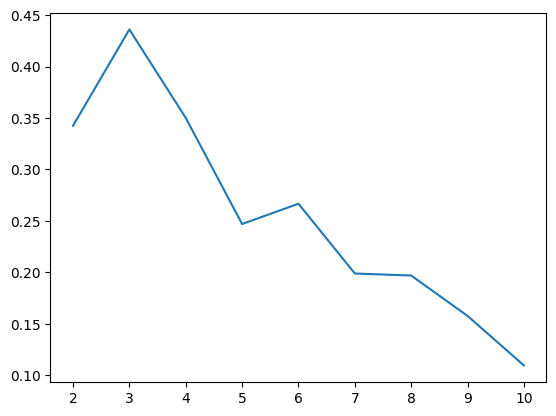

In [54]:
from sklearn.mixture import GaussianMixture

silhouette = []
for n_cl in range(2,11):
    mix = mixture.GaussianMixture(n_components=n_cl, random_state=42)
    labels = mix.fit_predict(pca)
    silhouette.append(metrics.silhouette_score(pca, labels))
plt.plot(range(2,11), silhouette);
print(f'Optimal number of clusters: {np.argmax(silhouette) + 2}')
print(f'Maximum silhouette coefficient value: {max(silhouette):.2f}')

### Давайте посмотрим на распределение кластеров.

2) Обучим лучшую модель (KMeans) с подобранным ранее количеством кластеров на декомпозированных данных. 
Сколько клиентов попало в самый большой кластер?



In [55]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(pca)
pd.DataFrame(np.unique(labels, return_counts=True))

,0,1,2
0,0,1,2
1,999,776,2269


Let's visualize the clustering results:

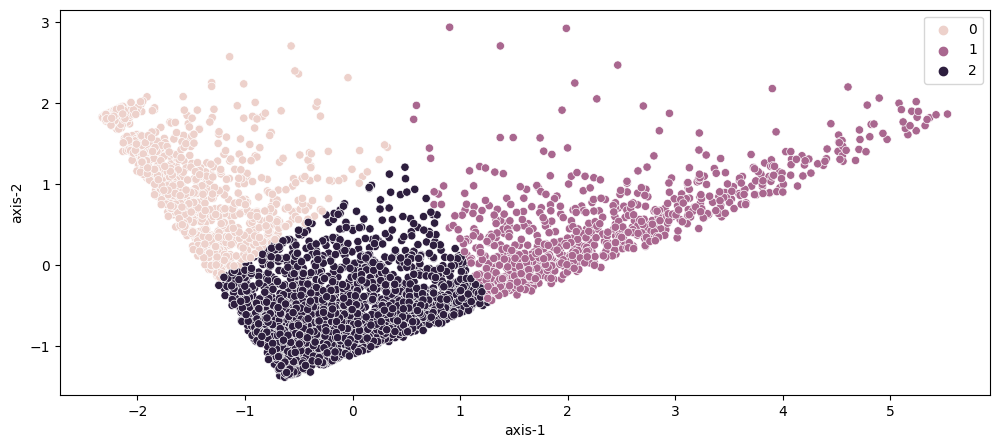

In [56]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    hue=labels,
);

So we have three customer segments. Let's try to create a profile for these segments.

### To profile the clusters, we need to return from the decomposed data to the RFM table, cleared of outliers. Let's group the RFM table according to the resulting clusters and calculate the average for each of the characteristics.

What is the maximum average value of the Frequency attribute in the resulting table? .

In [57]:
rfm_table_cleaned['Cluster'] = labels
rfm_pivot = rfm_table_cleaned.groupby('Cluster').mean().round()
rfm_pivot

,Recency,Frequency,Monetary
Cluster,,,
0,253.0,1.0,386.0
1,32.0,7.0,2658.0
2,51.0,2.0,660.0


## Polar diagram
Radar Chart is one of the ways to visualize the profile of clusters (polar, or radar, chart). It is a graphical representation of the meanings of several equivalent categories in the form of a "web".
Radar Chart is very often used in the context of cluster profiling. At the ends of the “web” axes are laid down, which correspond to the characteristics that describe the objects. On each axis for each cluster the average values of the corresponding characteristics are plotted. By connecting the points along the axes, we get a polygon.

The graph_objects module of the plotly library has a built-in Scatterpolar function that allows you to build a polar diagram. Based on this function, we implemented our own function plot_cluster_profile(), which allows you to visualize the profile of each of the clusters in the form of a polar diagram. This function has two parameters: grouped_data - characteristics of objects (clients) grouped into clusters, n_clusters - the number of clusters.

The main condition for using a polar diagram is that all features must be brought to a single scale using normalization, where 1 will mean the maximum, and 0 will mean the minimum. We also added a normalization step to the implementation of the plot_cluster_profile() function.

In [58]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Normalize the grouped data, bringing it to a scale of 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Create a list of features
    features = grouped_data.columns
    # Create an empty figure
    fig = go.Figure()
    # In the loop, visualize a polar diagram for each cluster
    for i in range(n_clusters):
        # Create a polar chart and add it to the general chart
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # radii
            theta=features, # serif name
            fill='toself', # fill the polygon with color
            name=f'Cluster {i}', # name - cluster number
        ))
    # Update the shape parameters
    fig.update_layout(
        showlegend=True, # display legend
        autosize=False, # set your chart sizes
        width=800, # width (in pixels)
        height=800, # height (in pixels)
    )
    # Display the figure
    fig.show()
    

Now we have a convenient tool for analyzing cluster profiles. Let's use it.

###
We visualize cluster profiles in the form of a polar diagram based on the average RFM characteristics calculated for each cluster.

Let's analyze the clusters and, based on the analysis, compare the cluster number and its description.

In [59]:
plot_cluster_profile(rfm_pivot, 3)

Cluster description:
* The cluster corresponds to “loyal” customers who generate the most income, make purchases most often, and are the least recent of their last purchase. Cluster 1
* The cluster corresponds to “intermediate” customers who are active, but do not buy as often or as much as loyal customers. At the same time, these clients are not “lost”. Cluster 2
* The cluster corresponds to “lost” customers who bought the least amount of goods and their last purchase was made a long time ago. Cluster 0

### 4. RFM customer segmentation: part 2

So, with the help of RFM analysis, we were able to identify three customer segments. However, in marketing it is customary to operate with a large number of them: usually marketers try to create a strategy for at least five to seven client segments in a gradation from “loyal” to “lost” with intermediate categories.

Therefore, having received feedback from marketers, we get back to work, trying to modify the resulting solution.

Previously, we performed clustering in principal component space. Recall that PCA is a linear method for mapping the original feature space to a compressed version of it.

What if you use a nonlinear transformation? For example, the t-SNE dimension reduction algorithm. Let's try it and see what happens.

### T-SNE
Let's use the t-SNE algorithm and transform the RFM table, cleared of outliers, into a two-dimensional representation. We will also take care of feature scaling in advance.

For convenience, let's wrap the data preprocessing steps in a pipeline.

Let's create a pipeline that will contain the following steps:
* standardization using StandardScaler with default parameters;
* t-SNE algorithm with two components, parameters perplexity=50 and random_state=100.

Let's train our pipeline on the RFM table (cleared of outliers) obtained earlier and apply a transformation to it.

What is the Kullback-Leibler divergence value for the trained t-SNE algorithm?
**Note:**
The Kullback-Leibler divergence is the loss function that is minimized when training the t-SNE algorithm. It shows a measure of the distance between two distributions.

The optimal value of this characteristic, found during the training of the t-SNE algorithm, is stored in the kl_divergence_ attribute of the TSNE class object from the sklearn library. Of course, the model must first be trained to obtain this value.



In [60]:
rfm_table_cleaned.drop(columns='Cluster', inplace=True)
pipeline_tsne = Pipeline([
    ('scaler', preprocessing.StandardScaler()), 
    ('tsne', manifold.TSNE(perplexity=50, random_state=100))
])
tsne = pipeline_tsne.fit_transform(rfm_table_cleaned)
print('{:.2f}'.format(pipeline_tsne['tsne'].kl_divergence_))

0.55


Having visualized the space after decomposition using t-SNE, we get the following picture:


In [61]:
rfm_table_processed = pd.DataFrame(tsne, columns=['axis-1', 'axis-2'])

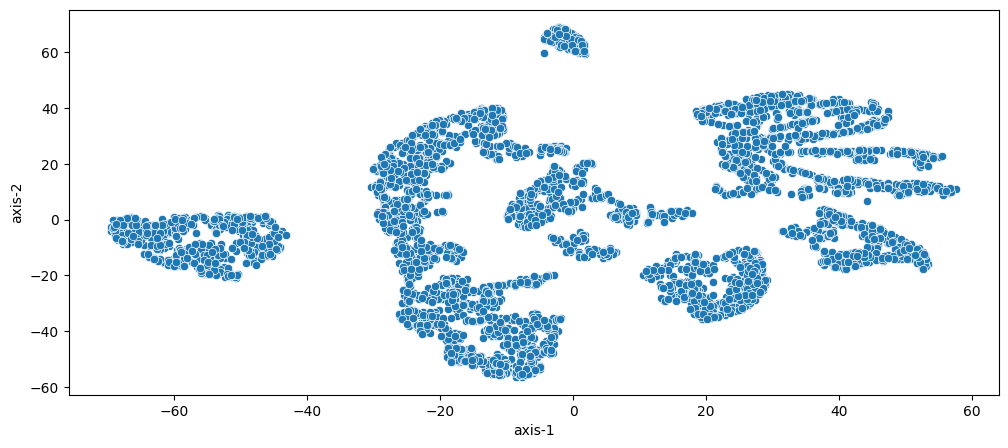

In [62]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

As expected from t-SNE, the algorithm grouped the most similar objects into similar clusters, and these clusters were easy to identify.

Now we will use clustering algorithms to form new customer segments.


### Let's try to use the k-means method.
Let's select the optimal number of clusters for the k-means method using the silhouette coefficient, sorting through possible values from 3 to 8 inclusive.
Let's take the number 42 as the value of the random_state parameter. Leave the remaining parameters as default.
Let's answer the questions:
1) Judging by the results obtained, what is the best number of clusters to take?

2) What is the maximum value of the silhouette coefficient?

Optimal number of clusters: 7
Maximum silhouette coefficient value: 0.51


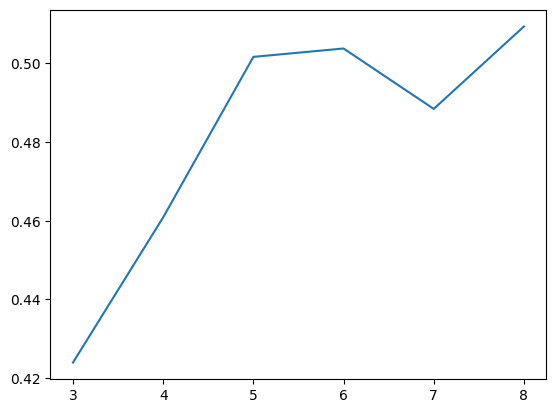

In [63]:
silhouette = []
for n_cl in range(3, 9):
    kmeans = cluster.KMeans(n_cl, random_state=42)
    kmeans.fit(tsne)
    silhouette.append(metrics.silhouette_score(tsne, kmeans.labels_))
plt.plot(range(3, 9), silhouette);
print(f'Optimal number of clusters: {np.argmax(silhouette) + 2}')
print(f'Maximum silhouette coefficient value: {max(silhouette):.2f}')

### Let's try to use the EM algorithm.

Let's select the optimal number of clusters for the EM algorithm (GaussianMixture) using the silhouette coefficient, we'll sort out the possible values from 3 to 8 inclusive.

Let's take the number 42 as the value of the random_state parameter. Leave the remaining parameters as default.

Let's answer the questions:
1) Judging by the results obtained, what is the best number of clusters to take?

2) What is the maximum value of the silhouette coefficient?

Optimal number of clusters: 4
Maximum silhouette coefficient value: 0.50


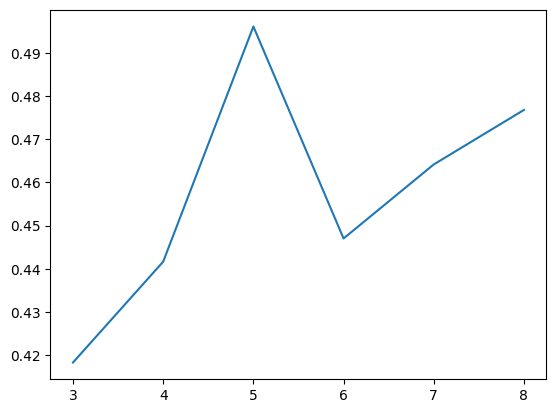

In [64]:
silhouette = []
for n_cl in range(3,9):
    mix = mixture.GaussianMixture(n_components=n_cl, random_state=42)
    labels = mix.fit_predict(tsne)
    silhouette.append(metrics.silhouette_score(tsne, labels))
plt.plot(range(3,9), silhouette);
print(f'Optimal number of clusters: {np.argmax(silhouette) + 2}')
print(f'Maximum silhouette coefficient value: {max(silhouette):.2f}')

### Let's try to use the algorithm of algorithmic clustering (AgglomerativeClustering).

Let's select the optimal number of clusters for the agglomerative clustering algorithm using the silhouette coefficient, sorting through possible values from 2 to 8 inclusive.

Leave all parameters, except for the number of clusters, at default.

Let's answer the questions:
1) Judging by the results obtained, what is the best number of clusters to take?

2) What is the maximum value of the silhouette coefficient?

Optimal number of clusters: 7
Maximum silhouette coefficient value: 0.52


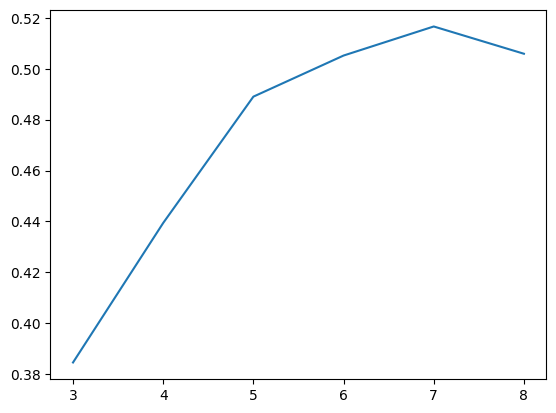

In [65]:
silhouette = []
for n_cl in range(3,9):
    aglo = cluster.AgglomerativeClustering(n_cl)
    aglo.fit(tsne)
    silhouette.append(metrics.silhouette_score(tsne, aglo.labels_))
plt.plot(range(3,9), silhouette);
print(f'Optimal number of clusters: {np.argmax(silhouette) + 3}')
print(f'Maximum silhouette coefficient value: {max(silhouette):.2f}')

### Let's look at the cluster distribution.

1) Let’s train the best model (AgglomerativeClustering) with the previously selected number of clusters on the decomposed data.
How many clients are in the largest cluster?

In [66]:
aglo = cluster.AgglomerativeClustering(7)
aglo.fit(tsne)
pd.DataFrame(np.unique(aglo.labels_, return_counts=True))

,0,1,2,3,4,5,6
0,0,1,2,3,4,5,6
1,719,904,725,508,651,423,114


Let's visualize the clustering results:

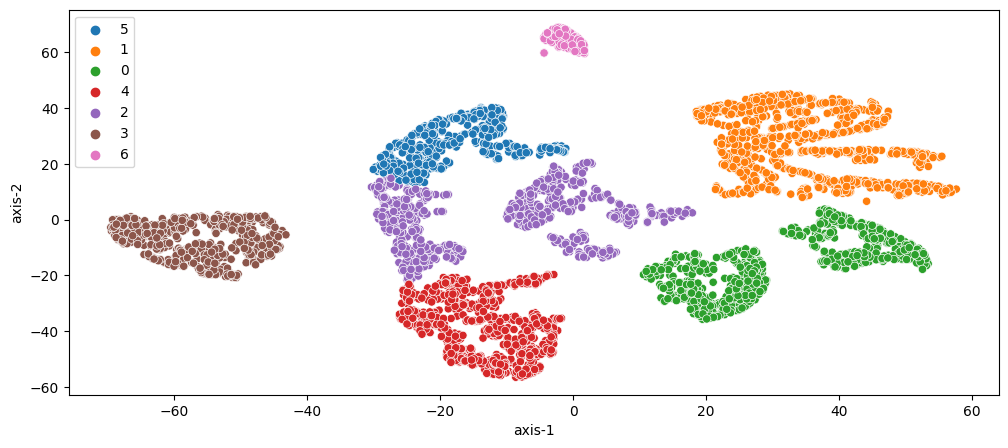

In [67]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2', hue=aglo.labels_.astype('str'));

So we have 7 customer segments. Let's try to create a profile for these segments.

To profile the clusters, we need to return from the decomposed data to the RFM table (cleared of outliers).

Let's group the RFM table according to the resulting clusters and calculate the average for each of the characteristics. For clarity, let's round all values in the columns to a whole number.

What is the maximum average value of the Recency attribute in the resulting table?

In [68]:
rfm_table_cleaned['Cluster'] = aglo.labels_
rfm_clasters = rfm_table_cleaned.groupby('Cluster').mean().round()
rfm_clasters

,Recency,Frequency,Monetary
Cluster,,,
0,44.0,3.0,967.0
1,33.0,7.0,2418.0
2,169.0,2.0,546.0
3,38.0,2.0,547.0
4,46.0,1.0,331.0
5,283.0,1.0,351.0
6,365.0,1.0,236.0


### Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

In [69]:
plot_cluster_profile(rfm_clasters, 7)

Let's analyze the clusters and, based on the analysis, compare the cluster number and its description.

* The cluster corresponds to “loyal” customers who generate the most income, make purchases most often, and are the least recent of their last purchase. Cluster 1.
* The cluster corresponds to “prospective” customers, who are active buyers, but do not buy as often or as much as loyal customers. Cluster 4.
* The cluster corresponds to “stranded” clients who relatively recently made several orders for small amounts. Potentially, these clients can be transferred to the “promising” cluster. Cluster 2.
* The cluster corresponds to “at risk” customers who have made several small purchases of goods, but their last purchase was made more than five months ago. Cluster 5.
* The cluster corresponds to “newbie” clients who relatively recently made one order for a small amount. Cluster 0.
* The cluster corresponds to “dormant” or “almost lost” customers who made one order for a small amount more than seven months ago and never returned. Cluster 6.
* The cluster corresponds to “lost” customers who bought the least amount of goods and their last purchase was made about a year ago. Cluster 3.

## 7. RFM client clustering: part 3

We built a clustering model for some clients. But how to make segment predictions for customers who were not included in the training set?

Using the predict() method is not quite that simple.

Recall that we trained our clustering algorithms on a t-SNE-compressed feature space. That is, in order to make a prediction for new objects that were not included in the sample, we will need to transform the features of these objects into a new compressed space.

However, the problem with t-SNE is that the algorithm is non-parametric. This means that, unlike algorithms such as PCA and SVD, it does not create an explicit mapping function. Simply put, the algorithm transforms the feature space for the training sample, but does not remember how it does it. This means that by feeding new objects into the algorithm to compress space, we will get a completely new representation of space that has no relation to what we built for the training set. That is, distortion will occur, which may lead to incorrect clustering results.

This is why the TSNE class from the sklearn library does not have a method such as transform(), it only has a method fit_transform() - retrain the t-SNE algorithm and perform the transformation.

How then can we perform clustering for new objects if we cannot compress the dimension for new data?

Let's reduce the clustering problem to a classification problem. Indeed, we now have true cluster labels, and there are clients that are described by RFM characteristics. Let's train a model that will predict the customer segment based on RFM characteristics.

### Divide the original data into training and test sets in a ratio of 80/20. Let's take the number 42 as the random_state parameter.

In [70]:
# We create a matrix of observations X and a vector of correct answers y
X = rfm_table_cleaned.drop(columns='Cluster') #cleaned RFM table
y = rfm_table_cleaned['Cluster'] #cluster labels predicted earlier
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
y_test.shape[0]

809

Then all we have to do is build several models and choose the best one.
We know that the t-SNE algorithm is a non-linear dimensionality reduction method. We can safely assume that linear models such as logistic regression will not help us much in this task.

Therefore, let's immediately take the heavy artillery - ensemble algorithms.


### Let's start with a random forest. Using GridSearchCV, we organize the search of random forest parameters (RandomForestClassifier) on the following grid of parameters:

```
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
```
We use the number 42 as the random_state parameter for the random forest model.
We use accuracy as a metric. The number of folds for cross-validation is 5.

1) Train GridSearchCV on the training set. What is the optimal maximum tree depth in a random forest?

2) Using the best model, we will make a prediction for the test sample and calculate the accuracy metric.



In [71]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

grid_search = model_selection.GridSearchCV(
    estimator = ensemble.RandomForestClassifier(
        random_state=42), 
    param_grid=param_grid, 
    scoring = 'accuracy',
    cv=5, 
    n_jobs = -1
)  
grid_search.fit(X_train, y_train) 
print(f'Best parameters: {grid_search.best_params_}')
y_test_pred = grid_search.predict(X_test)
print('Test accuracy score: {:.3f}' \
    .format(metrics.accuracy_score(y_test, y_test_pred)))

Best parameters: {'criterion': 'gini', 'max_depth': 13, 'n_estimators': 100}
Test accuracy score: 0.988


So, the value of the accuracy metric is very high, but not ideal. Let's try to improve it using boosting.

### Using GridSearchCV, we organize the enumeration of gradient boosting parameters (GradientBoostingClassifier) on the following grid of parameters:
```
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
```

We use the number 42 as the random_state parameter for the gradient boosting model.
We use accuracy as a metric. The number of folds for cross-validation is 5.

1) Let's train GridSearchCV on the training set. What is the optimal maximum tree depth in gradient boosting?
Answer: 6
2) Using the best model, we will make a prediction for the test sample and calculate the accuracy metric.

In [72]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

grid_search = model_selection.GridSearchCV(
    estimator = ensemble.GradientBoostingClassifier(
        random_state=42), 
    param_grid=param_grid, 
    scoring = 'accuracy',
    cv=5, 
    n_jobs = -1
)  
grid_search.fit(X_train, y_train) 
print(f'Best parameters: {grid_search.best_params_}')
y_test_pred = grid_search.predict(X_test)
print('Test accuracy score: {:.3f}' \
    .format(metrics.accuracy_score(y_test, y_test_pred)))

Best parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500}
Test accuracy score: 0.993


Great, we have dealt with the problem of non-parametricity of t-SNE and were able to move from solving a clustering problem to a classification problem. Now we have a model that, based on the client’s RFM characteristics, automatically determines its segment.

In [73]:
# Let's fix the version of the packages so that the experiments are reproducible:
!pip freeze > requirements.txt